# ImageCaptioning - Inference 

Use the trained model on unseen images.

In [1]:
from pycocotools.coco import COCO
from imcaption.data_loader import get_transform, get_loader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transform to pre-process the testing images. .. Same as tx used on training .. 
transform_test = get_transform()

# Create the data loader.
data_loader = get_loader(transform=transform_test, mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [2]:
import os
import torch
from imcaption.model import EncoderCNN, DecoderRNN
import matplotlib.pyplot as plt
import numpy as np

# Specify the saved models to load.
models_folder = 'models'
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join(models_folder, encoder_file)))
decoder.load_state_dict(torch.load(os.path.join(models_folder, decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(4532, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=4532, bias=True)
)

In [3]:
def clean_sentence(output):
    """ Clean up the generated sentence. """
    sentence = [data_loader.dataset.vocab.idx2word[x] for x in output]
    
    # Cut the sentence at the first occurrence of the <end> tag
    end_word_idx = data_loader.dataset.vocab.end_word
    
    if(end_word_idx in sentence):
        idx = sentence.index(end_word_idx)
        sentence = sentence[:idx]
        
    # Remove <start> and <unk> 
    start_word = data_loader.dataset.vocab.start_word
    unk_word = data_loader.dataset.vocab.unk_word
    sentence = [x for x in sentence if x not in [start_word, unk_word]]
    
    return " ".join(sentence)

def get_prediction():
    """ Load an image from the test dataset and generate a caption. """
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

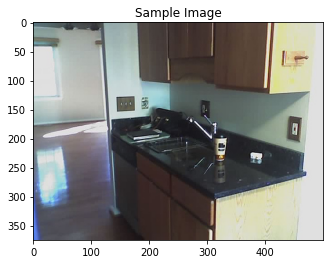

a view of a kitchen 's refrigerator , and sink .


In [4]:
get_prediction()